# Tutorial

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
import regvelovi
from regvelovi import REGVELOVI,sanity_check,prior_GRN,abundance_test,TFscreening
from velovi import preprocess_data
import cellrank as cr

import mplscience
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist

[rank: 0] Global seed set to 0


## Load datasets

In [2]:
adata = regvelovi.datasets.zebrafish_nc()
prior_net = regvelovi.datasets.zebrafish_grn()
TF_list = adata.var_names[adata.var["is_tf"]].tolist()

  0%|          | 0.00/40.2M [00:00<?, ?B/s]

In [3]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
scv.pp.moments(adata)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


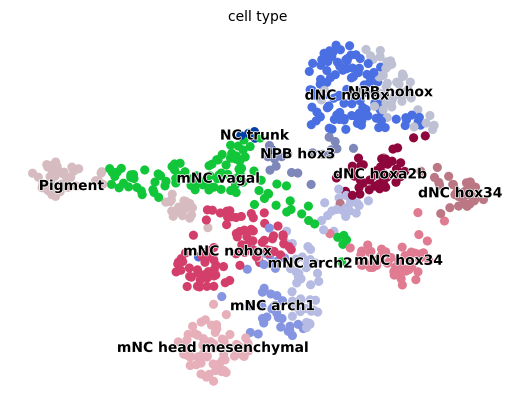

In [4]:
scv.pl.umap(adata, color='cell_type')

## Preprocessing

In [5]:
adata = preprocess_data(adata)
adata = prior_GRN(adata,prior_net)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [6]:
#adata = sanity_check(adata)

In [7]:
TF_list = set(TF_list).intersection(adata.var_names)
TF_list = list(TF_list)
print("final number of TF: "+str(len(TF_list)))

final number of TF: 80


In [8]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W))

In [9]:
sparsity = W.sum() / ((W.sum(1) != 0).sum() * W.shape[0])
print("network sparsity: "+str(np.array(sparsity)))

network sparsity: 0.05279029


In [10]:
adata.shape

(697, 999)

## Training RegVelo model

In [11]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T,regulators = TF_list,soft_constraint = False)

In [12]:
reg_vae.train()

/home/icb/weixu.wang/miniconda3/envs/cellrank2/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/cellrank2/lib/p ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/cellrank2/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/cellrank2/lib/p ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80

Epoch 998/1500:  66%|██████▋   | 997/1500 [05:56<02:55,  2.87it/s, loss=-2.09e+03, v_num=1]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [13]:
reg_vae.save("rgv_model")

In [14]:
adata_target = reg_vae.add_regvelo_outputs_to_adata(adata = adata)

In [15]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/128 cores)


  0%|          | 0/697 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Predict terminal states

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Defaulting to `'gmres'` solver.


  0%|          | 0/4 [00:00<?, ?/s]

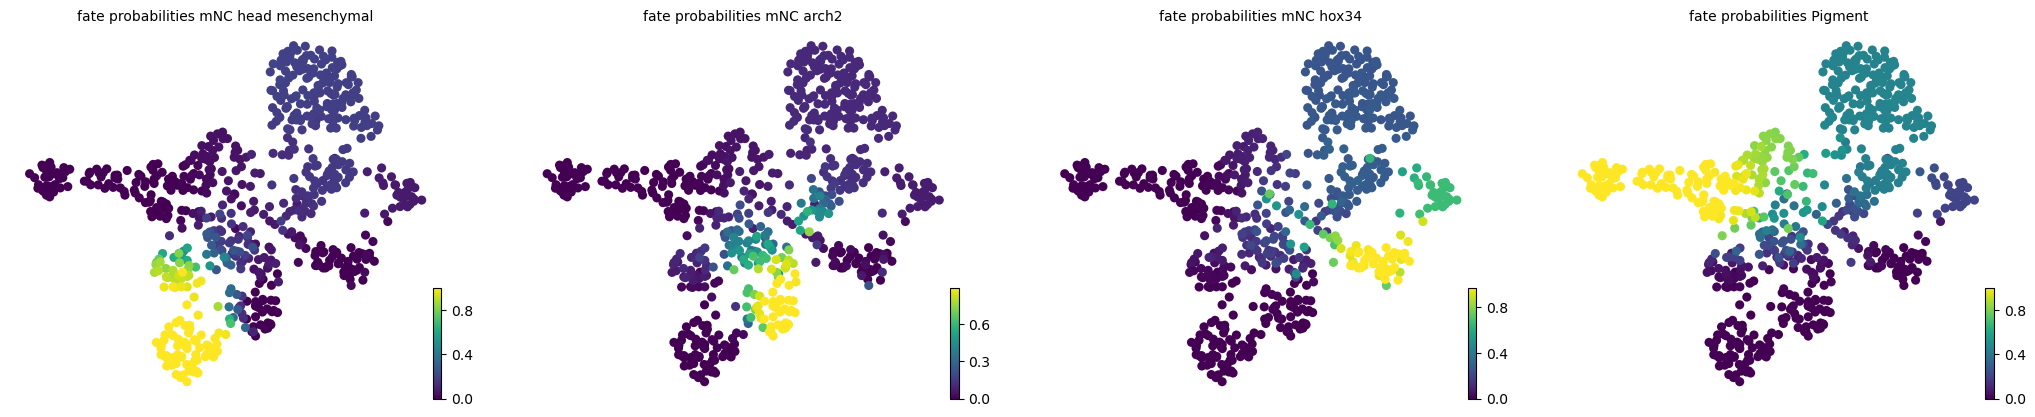

In [16]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]
vk = cr.kernels.VelocityKernel(adata_target)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()
g_raw = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
g_raw.compute_macrostates(n_states=8,cluster_key="cell_type")
g_raw.set_terminal_states(terminal_states)
g_raw.compute_fate_probabilities()
g_raw.plot_fate_probabilities(same_plot=False)

/home/icb/weixu.wang/miniconda3/envs/cellrank2/lib/python3.8/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/cellrank2/lib/python3.8/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/cellrank2/lib/python3.8/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/icb/weixu.wang/miniconda3/envs/cellrank2/lib/python3.8/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


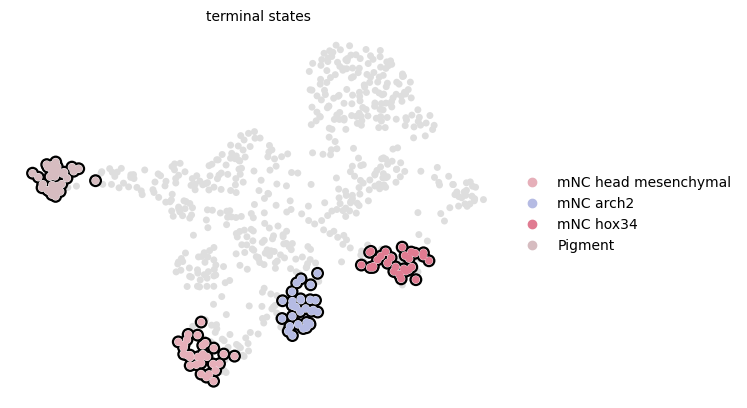

In [17]:
g_raw.plot_macrostates(which="terminal", legend_loc="right", s=100)

## Perform perturbation screening

In [18]:
## Perform perturbation simulation
fate_prob_perturb = []
cand_list = ["nr2f5","sox9b","twist1a","twist1b","sox10","mitfa","tfec","tfap2a","tfap2b"]
for TF in cand_list:
    model = 'rgv_model'
    adata_target_perturb,reg_vae_perturb =  regvelovi.in_silico_block_simulation(model,adata,TF)
    ### predict the terminal state dfference
    n_states = 8
    vk = cr.kernels.VelocityKernel(adata_target_perturb)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata_target_perturb).compute_transition_matrix()
    g = cr.estimators.GPCCA(vk)
    ## evaluate the fate prob on original space
    g.compute_macrostates(n_states=n_states,cluster_key="cell_type")
    g.set_terminal_states(terminal_states)
    g.compute_fate_probabilities()
    ## visualize coefficient
    cond1_df = pd.DataFrame(adata_target_perturb.obsm["lineages_fwd"], columns=adata_target_perturb.obsm["lineages_fwd"].names.tolist())

    fate_prob_perturb.append(cond1_df)

INFO     File rgv_model/model.pt already downloaded                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

In [19]:
cond2_df = pd.DataFrame(adata_target.obsm["lineages_fwd"], columns=adata_target.obsm["lineages_fwd"].names.tolist())
df_list = []
for i in range(len(fate_prob_perturb)):
    #data = np.array(((fate_prob_perturb[i]+1) - (cond2_df+1)))
    data = abundance_test(cond2_df, fate_prob_perturb[i])
    data = pd.DataFrame({"Score": data.iloc[:,0].tolist(),
                     "Terminal state": data.index.tolist(),
                     "TF":[cand_list[i]]*(data.shape[0])})
    df_list.append(data)

In [20]:
df = pd.concat(df_list)

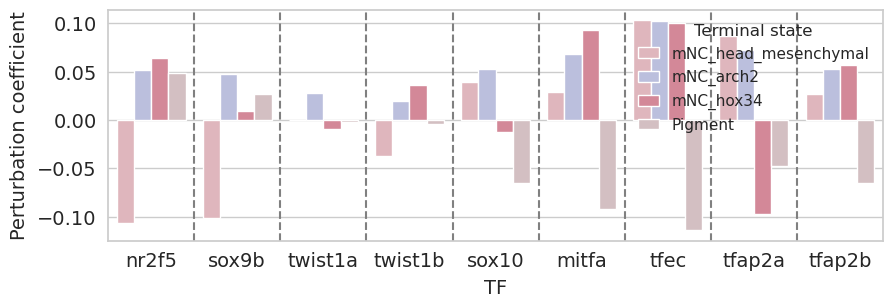

In [21]:
with mplscience.style_context():
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10,3))
    #sns.barplot(x='Terminal state', y='AUROC',data=data, hue = "Method",palette=pal,ax = ax)
    color_label = "cell_type"
    palette = dict(zip(adata.obs[color_label].cat.categories, adata.uns[f"{color_label}_colors"]))
    subset_palette = {name: color for name, color in palette.items() if name in cond2_df.columns.tolist()}

    sns.barplot(x='TF', y='Score', hue='Terminal state', data=df, ax=ax, palette=palette, dodge=True)

    # Add vertical lines to separate groups
    for i in range(len(df['TF'].unique()) - 1):
        plt.axvline(x=i + 0.5, color='gray', linestyle='--')

    # Label settings
    plt.ylabel('Perturbation coefficient', fontsize=14)
    plt.xlabel('TF', fontsize=14)
    plt.xticks(fontsize=14)  # Increase font size of x-axis tick labels
    plt.yticks(fontsize=14)  # Increase font size of y-axis tick labels
    plt.show()

## Screening different KO combination

In [22]:
KO_list = ["tfec","mitfa","fli1a_sox9b","nr2f5"]
perturb_coef,perturb_pval = TFscreening(adata = adata,
            prior_graph = W.T,
            soft_constraint = False,
            TF_list = TF,
            cluster_label = "cell_type",
            terminal_states = terminal_states,
            KO_list = KO_list,
            n_states = 8,
            cutoff = 0)

training model...


/home/icb/weixu.wang/miniconda3/envs/cellrank2/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/cellrank2/lib/p ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/cellrank2/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/cellrank2/lib/p ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80

Epoch 997/1500:  66%|██████▋   | 997/1500 [05:40<02:53,  2.90it/s, loss=-2.12e+03, v_num=1]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [23]:
perturb_coef

,mNC_head_mesenchymal,mNC_arch2,mNC_hox34,Pigment
fli1a_sox9b,-0.152963,-0.053741,0.079179,0.062450
mitfa,0.076299,0.101077,0.109286,-0.114369
nr2f5,-0.102868,0.053834,0.074721,0.014614
tfec,0.108965,0.121379,0.106056,-0.120015
